In [3]:
import sys
print(sys.version)

3.12.3 (main, Sep 11 2024, 14:17:37) [GCC 13.2.0]


In [18]:
#
# Load and extract the 327k bucket names downloaded from Grayhat Warfare
#
# The provided S3 names contain complete AWS domain information as well, which will be one of the following formats:
# 1) [bucket_name].s3.amazonaws.com
# 2) [bucket_name].s3-[aws_region].amazonaws.com
# 3) [bucket_name].s3.[aws_region].amazonaws.com
# 
#
import json, re

def extract_bucket_name(bucket_url):
    # Define regex pattern to match and capture the bucket name
    pattern = r"^(.+)?\.s3(?:[\.-])(.+)?amazonaws.com(?:\.[a-z]{2})?$"
    
    # Search for the pattern in the given URL
    match = re.match(pattern, bucket_url)
    
    # Return the bucket name if found, otherwise None
    return match.group(1) if match else None


with open('buckets.json', 'r') as f:
    gh_data = json.load(f)

bucket_names = [x['bucket'] for x in gh_data]
bucket_names = [extract_bucket_name(x) for x in bucket_names]
bucket_names = [b for b in bucket_names if b is not None]

# Save point, all bucket names minus the AWS domains
with open('parsed_buckets.json', 'w') as f:
    json.dump(bucket_names, f, indent=2)

In [139]:
#
# Let's attempt to tokenize
#
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

##
## Due to weird behavior, I ended up downloading *all* corpora and models to get the
## punkt tokenizer operational.
##
#nltk.download()

import json

with open('parsed_buckets.json') as f:
    buckets = json.load(f)

# Start with a simple Regex based tokenizer for the light work.
custom_tokenizer = RegexpTokenizer(r'\d+|[a-zA-Z]+')
tokenized_buckets = []
for b in buckets:
   tokenized_buckets.append(custom_tokenizer.tokenize(b.lower()))

from wordsegment import load, segment
load()
results = []
for bucket in tokenized_buckets:
    current_tokens = []
    for b in bucket:
       current_tokens.extend(segment(b))
    results.append(current_tokens)

with open("tokenized_buckets.json", "w") as f:
    json.dump(results, f, indent=2)
# print(results)


# print("compound" in english_words)
# from wordsegment import load, segment
# load()

    
# NOTE: Bert broke words based on tokens with no regard for the english dictionary
# Move on to a BERT based tokenizer to split words such as "websitecontent" and "siliconvalley"
# from transformers import BertTokenizer
# import torch
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# for bucket_tokens in tokenized_buckets[30:50]:
#     for token in bucket_tokens:
#         print(f"Input: {token}, output: {tokenizer.tokenize(token)}")
# print(tokenized_buckets[50:100])




In [134]:
# from wordfreq import top_n_list

# # Approx 235k English words, we need to remove single letters
# english_words = top_n_list("en", 10000)
# english_words = set([word for word in english_words if len(word) > 2])

# # print("\n".join(english_words))

# inputs = [
#     "compoundword",
#     "myscreenshots",
#     "screenshotlibrary",
#     "asdfbasdfdsaf",
#     "mygarbageghggfgfgf",
#     "resource3",
#     "legitimatedefensecontractor"
# ]

# def dictionary_split(input_word) -> list:
#     # print(f"Testing {input_word}")
#     splits = []
#     for i in range(1, len(input_word)-1):
#         prefix, suffix = input_word[:i], input_word[i:]

#         if english_words.issuperset({prefix, suffix}):
#             # Both words are a match, end it here
#             # print(f"Appending {prefix, suffix}")
#             splits.append([prefix, suffix])
#         elif prefix in english_words:
#             # We've matched a word based on the prefix. Recurse for the suffix, and
#             # add the combination as a contender
#             current_split = [prefix]
#             current_split.extend(dictionary_split(suffix))
#             splits.append(current_split)            
#         elif suffix in english_words:
#             # We've matched a word based on the suffix. Recurse for the suffix, and
#             # add the combination as a contender
#             current_split = dictionary_split(prefix)
#             current_split.append(suffix)
#             splits.append(current_split)
            
#     # After iteration, if splits is empty then return the full word.  Otherwise return the 
#     # Split with the least number of words
#     if len(splits) == 0:
#         return [input_word]
#     else:
#         min_splits = splits[0]
#         for test_split in splits:
#             if len(test_split) < len(min_splits):
#                 min_splits = test_split
#         return min_splits    

# # print("compound" in english_words)
# from wordsegment import load, segment
# load()


# for input in inputs:
#     print(segment(input))

['compound', 'word']
['my', 'screenshots']
['screenshot', 'library']
['asdfbasdfdsaf']
['my', 'garbage', 'ghg', 'gfg', 'fgf']
['resource', '3']
['legitimate', 'defense', 'contractor']


In [87]:
#
# Tag all bucket tokens with parts of speech with NLTK
# 
from nltk.corpus import brown
from nltk.tag import UnigramTagger, RegexpTagger


def build_base_tagger(backoff_tagger):
    # Load tagged sentences from different categories in the Brown corpus
    train_data_news = brown.tagged_sents(categories='news')
    train_data_fiction = brown.tagged_sents(categories='fiction')
    train_data_hobbies = brown.tagged_sents(categories='hobbies')
    train_data_government = brown.tagged_sents(categories='government')

    # Create UnigramTaggers with backoffs in sequence to broaden coverage
    # Start with the most domain-specific tagger and chain others as backoffs
    government_tagger = UnigramTagger(train_data_government, backoff=backoff_tagger)  # Lowest priority tagger
    hobbies_tagger = UnigramTagger(train_data_hobbies, backoff=government_tagger)
    fiction_tagger = UnigramTagger(train_data_fiction, backoff=hobbies_tagger)
    return UnigramTagger(train_data_news, backoff=fiction_tagger)  # Primary tagger    
    

PHASE = ['alpha', 'beta', 'test']
INFRA = ['test', 'logs', 'download', 'staging', 'dev', 'www', 'web', 'cdn', 'images', 'blog', 'vpn', 'website', 'files', 'os', 'pub'
         'files', 'app', 'public', 'scripts', 'static', 'git', 'devs', 'stats', 'db', 'wiki', 'aws', 'gcp', 'bucket', 'sandbox', 'server'
         'temp', 'build', 'builds', 'downloads', 'log', 'backup', 'cassandra', 'demo', 'api', 'docs', 'dashboard', 'doc', 'ops', 'backend'
         'media', 'cache', 'screenshots', 'media', 'pics', 'android', 'cms', 'content', 'img', 'uploads', 'assets', 'backups']
WEB = ['videos', 'tech', 'portal', 'online', 'photos', 'hub', 'upload', 'lab', 'apps', 'email', 'audio', 'photo', 'id', 'user', 
       'pdf', 'software', 'podcast', 'wordpress', 'hosting', 'templates', 'webapp', 'logos', 'fonts', 'ios', 'crypto', 'logo', 'dist']
DEV = ['stack', 'src', 'repo', 'developer', 'playground', 'hash', 'admin', 'js', 'bot', 'sys', 'cli', 'console', 'firmware']
TLD = ['com', 'net', 'org', 'io', 'edu', 'uk','cn', 'eu', 'gov']
CITY = ['chicago', 'houston', 'nyc', 'dallas', 'vegas', 'phoenix', 'london', 'atlanta', 'denver', 'orlando', 'tokyo' 'seattle', 'sydney', 'charlotte', 
        'boston', 'brooklyn', 'columbus', 'portland', 'philadelphia', 'singapore']
ST_ABBRV = ['tx', 'fl', 'ny', 'wa', 'oh', 'nj', 'dc', 'ct', 'ut', 'ks', 'ak', 'nv', 'nd', 'nh']
with open("country_codes.json", 'r') as f:
    ccs = json.load(f)
CC = list(ccs.keys())


custom_terms = []
custom_terms.extend([(key, 'PHASE') for key in PHASE])
custom_terms.extend([(key, 'INFRA') for key in INFRA])
custom_terms.extend([(key, 'TLD') for key in TLD])
custom_terms.extend([(key, 'DEV') for key in DEV])
custom_terms.extend([(key, 'CITY') for key in CITY])
custom_terms.extend([(key, 'WEB') for key in WEB])
custom_terms.extend([(key, 'ST_ABBRV') for key in ST_ABBRV])
custom_terms.extend([(key.lower(), 'CC_TLD') for key in CC])
custom_terms = [custom_terms]

# Regex tagging for various items
patterns = [
    (r'^[\d+]{1,2}$', 'DIG'), # Digits
    (r'^[\d+]{3}$', '3DIG'),  # 3 Digits
    (r'^[\d+]{4}$', '4DIG'),  # 4 Digits
    (r'^[\d+]{5,}$', 'LDIG'), # 5 or more Digits
    (r'^[a-z]{2}$', '2ALPHA'),# 2 Alphabet characters
    (r'^[a-z]$', 'ALPHA'),    # Alphabet character

]

# Create the RegexpTagger
regex_tagger = RegexpTagger(patterns)
base_tagger = build_base_tagger(regex_tagger)
tagger = UnigramTagger(custom_terms, backoff=base_tagger)

with open("tokenized_buckets.json", "r") as f:
    buckets = json.load(f)


tagged_buckets = [tagger.tag(bucket) for bucket in buckets]

with open("tagged_buckets.json", "w") as f:
    json.dump(tagged_buckets, f, indent=2)


In [88]:
import json

with open("tagged_buckets.json", "r") as f:
    tagged_buckets = json.load(f)

untagged_counts = {}
for bucket in tagged_buckets:
    for tag_pair in bucket:
        txt = tag_pair[0]
        tag = tag_pair[1]

        if tag == None:
            count = untagged_counts.get(txt, 0)
            count = count + 1
            untagged_counts[txt] = count
sorted_untagged_counts = dict(sorted(untagged_counts.items(), key=lambda item: item[1], reverse=True))

with open("untagged_tokens.json", "w") as f:
    json.dump(sorted_untagged_counts, f, indent=2)
    
    

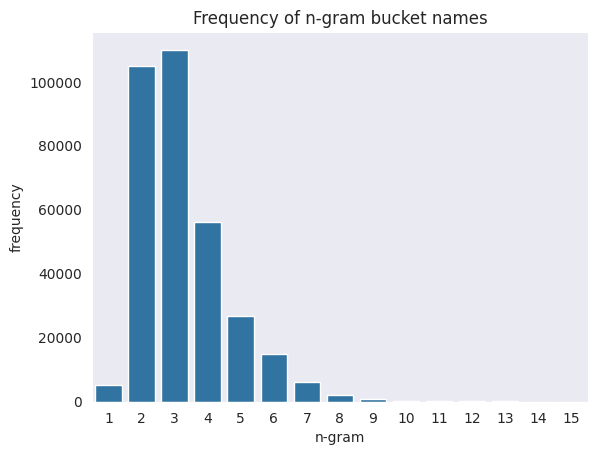

In [99]:
#
# Let's get some statistics on the n-gram tokens
#
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

n_grams = {}

with open("tagged_buckets.json", "r") as f:
    tagged_buckets = json.load(f)

for bucket_tags in tagged_buckets:
    tag_len = len(bucket_tags)
    count = n_grams.get(tag_len, 0)
    count = count + 1
    n_grams[tag_len] = count


#
# To prevent the long-tail from clogging up our view, filter out any n-grams with
# less than 50 count (out of 327,000)
#
filtered_n_grams = {key: value for key, value in n_grams.items() if value >= 50}

# Convert dictionary to DataFrame
df = pd.DataFrame(list(filtered_n_grams.items()), columns=["Key", "Value"])

# Sort the DataFrame by "Key" to match ascending key order
df = df.sort_values(by="Key")


# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Apply the scaler to normalize all values in the DataFrame
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Plot the frequency with Seaborn
sns.set_style("dark")
sns.barplot(x="Key", y="Value", data=df)
plt.title("Frequency of n-gram bucket names")
plt.xlabel("n-gram")
plt.ylabel("frequency")
plt.show()




In [ ]:
import json

with open("tagged_buckets.json", "r") as f:
    tagged_buckets = json.load(f)

#
# Given a list of tokenized and tagged buckets, return a map of transition counts between
# the tag types
#
# Keys are compund and of the form '<src>-<dst>'
#
def build_transition_counts(buckets) -> dict:
    transition_counts = {}

    ignored = 0
    for bucket in buckets:
        blen = len(bucket)
        if blen == 1:
            ignored = ignored +1
            continue # We can't operate on a unigram bucket name
        # Each bucket is a list(list(txt, tag)) , We only care about the tag and the following tag.
        src_tag = None
        for pair in bucket:
            tag = pair[1]
            if src_tag == None:
                # This is our first time through, save the tag and continue
                src_tag = tag
                continue
            else:
                # Mark the transition
                key = f"{src_tag}/{tag}"
                count = transition_counts.get(key, 0)
                count = count + 1
                transition_counts[key] = count
                src_tag = tag
    print(f"Ignored {ignored} unigram buckets")
    return transition_counts

counts = build_transition_counts(tagged_buckets)
sorted_counts = {key: value for key, value in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
sum = 0
for key, value in counts.items():
    sum = sum + value
print(f"{sum} total transitions")
print(sorted_counts)


Ignored 5316 unigram buckets
507484 total transitions
{'NN/NN': 32903, 'NN/None': 24978, 'INFRA/None': 17443, 'NN/INFRA': 17012, 'NN/TLD': 13028, 'INFRA/NN': 9879, 'INFRA/INFRA': 9671, 'ALPHA/None': 9508, 'CC_TLD/None': 9376, 'JJ/NN': 9058, 'ALPHA/CD': 8488, 'CC_TLD/TLD': 8223, 'IN/None': 7934, 'NN/NNS': 7048, 'NN/CC_TLD': 6741, '2ALPHA/None': 6353, 'JJ/None': 5633, 'NN/IN': 5381, 'CC_TLD/NN': 5366, 'VB/None': 4697, 'ALPHA/NN': 4668, 'VB/NN': 4313, 'CC_TLD/INFRA': 4153, 'NN/VB': 3952, 'TLD/CC_TLD': 3948, '2ALPHA/NN': 3758, 'CD/ALPHA': 3681, 'CD/None': 3512, 'NN/CD': 3510, 'NN/ALPHA': 3497, '2ALPHA/INFRA': 3424, 'AT/None': 3371, 'NNS/TLD': 3306, 'CC_TLD/CC_TLD': 3304, 'VB/INFRA': 3278, 'ST_ABBRV/TLD': 3259, 'NNS/None': 3244, 'NN/WEB': 3122, 'ALPHA/INFRA': 3089, 'CD/INFRA': 3018, 'NN/JJ': 2988, 'INFRA/VB': 2674, 'CD/NN': 2656, 'AT/NN': 2585, 'JJ/INFRA': 2550, 'INFRA/CC_TLD': 2509, 'INFRA/CD': 2502, 'IN/NN': 2462, 'NNS/NN': 2440, 'NNS/INFRA': 2331, 'NN/2ALPHA': 2311, '2ALPHA/TLD': 2306, '

In [98]:
#
# Let's figoure out how many unique tags we have here
#
import json

with open('tagged_buckets.json', 'r') as f:
    tagged_buckets = json.load(f)

tags = set()

for bucket in tagged_buckets:
    for tag_tuple in bucket:
        tags.add(tag_tuple[1])

print(len(tags))
print(tags)

103
{'UH', 'HVZ', 'VBD', '2ALPHA', 'HV+TO', 'CITY', 'CC', 'JJT', 'BEN', None, 'ST_ABBRV', 'VBN+TO', 'HVD', '*', 'PN', 'FW-AT', 'BEZ', 'BEDZ', 'FW-RB', 'PPS', 'WP$', 'NP', 'TLD', 'AP', 'VB-HL', 'VB+TO', 'NR', 'BEM', 'VB', 'DIG', 'MD', 'VBN-HL', 'TO', 'FW-*-TL', 'DTS', 'ABN', 'FW-NNS', '4DIG', 'VBG', 'DO', 'LDIG', 'FW-BER', 'DOD', 'AT', 'DOZ', 'HV', 'HVG', 'PP$', 'RP', 'BED', 'CD', 'FW-JJ', 'NN', 'OD', 'WRB', 'VBG-HL', 'IN', 'NN-NC', 'RB', 'CS', 'PHASE', 'FW-NN', 'VBZ', 'INFRA', 'JJR', 'FW-CC', 'WPS', 'DT', 'NNS-HL', 'NN-HL', 'VBG+TO', 'ABX', 'CC_TLD', 'PP$$', 'FW-RB-TL', 'WDT', 'JJ', '3DIG', 'FW-DT', 'PPSS', 'RBR', 'FW-PPSS', 'DEV', 'FW-PP$', 'EX', 'CD-TL', 'VBZ-HL', 'QL', 'BER', 'FW-WDT', 'DTI', 'WEB', 'PPO', 'PPL', 'JJS', 'JJ-HL', 'NNS', 'BEG', 'JJR-HL', 'VBN', 'FW-IN', 'ALPHA', 'FW-CD'}


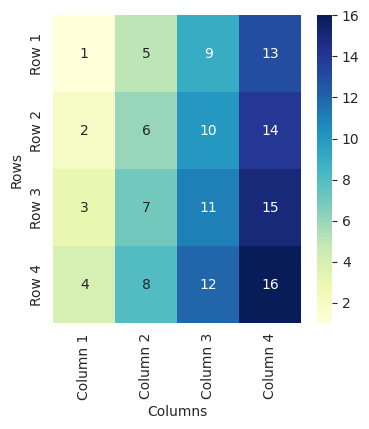

In [85]:
import pandas as pd

# Creating a 4x4 matrix
data = {
    'Column 1': [1, 2, 3, 4],
    'Column 2': [5, 6, 7, 8],
    'Column 3': [9, 10, 11, 12],
    'Column 4': [13, 14, 15, 16]
}
df = pd.DataFrame(data)

# Naming the row and column indexes
df.index = ['Row 1', 'Row 2', 'Row 3', 'Row 4']
df.index.name = 'Rows'
df.columns.name = 'Columns'

df

import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap
plt.figure(figsize=(4, 4))  # Adjust size if needed
sns.heatmap(df, annot=True, cmap="YlGnBu", cbar=True)

# Display the heatmap
plt.show()